In [1]:
import pandas as pd

historydf= pd.read_csv('C:/Users/veryv/OneDrive/桌面/Stock_data/full_history/A.csv', index_col=0 )
historydf.dropna(how='any',inplace=True)

In [7]:
from sklearn import preprocessing

def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    newdf['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    newdf['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    newdf['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    newdf['adjclose'] = min_max_scaler.fit_transform(df.adjclose.values.reshape(-1,1))
    
    return newdf

historydf_norm= normalize(historydf)


C:\Users\veryv\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [42]:
historydf_norm=historydf_norm.astype('float32')

In [19]:
historydf_norm.head()

,volume,open,close,high,low,adjclose
date,,,,,,
2019-04-18,0.037756,0.654993,0.645533,0.635467,0.704709,0.755011
2019-04-17,0.063523,0.678277,0.638550,0.651961,0.695874,0.746964
2019-04-16,0.046906,0.703967,0.658555,0.676424,0.724250,0.770016
2019-04-15,0.017651,0.705699,0.685449,0.677999,0.752522,0.801006
2019-04-12,0.011556,0.709836,0.690922,0.686617,0.762812,0.807313


In [55]:
import numpy as np

def data_split(data,sample):
    # 資料維度: 開盤價、收盤價、最高價、最低價、成交量... 6維
    feature = len(data.columns)
    
    # 將dataframe 轉成 numpy array
    data = data.as_matrix()
    newdata = []
    y_data = []
    # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
    for i in range(len(data)-sample):# 從 datavalue 的第0個跑到倒數第 time_frame+1 個
        newdata.append(data[i:(i+sample)])# 逐筆取出 time_frame+1 個 K棒數值做為一筆 instance
        y_data.append(data[i+sample,-1:])
        
    n_train = round(0.8*len(newdata))# 取 result 的前 80% instance做為訓練資料
    newdata = np.array(newdata)
    
    x_train = newdata[:int(n_train), :-1] # 訓練資料中, 只取每一個 time_frame 中除了最後一筆的所有資料做為feature
    y_train = y_data[:int(n_train)] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案
    
    # 測試資料
    x_test = newdata[int(n_train):,:-1]
    y_test = newdata[int(n_train):,-1:]
    
    # 將資料組成變好看一點
    x_train = x_train.reshape(-1, 1, 2)
    y_train = x_train.reshape(-1, 1, 2)
    x_test = x_test.reshape(-1, 1, 2)
    
    return x_train,y_train,x_test,y_test

# 以30天為一區間進行股價預測
x_train,y_train,x_test,y_test = data_split(historydf_norm,2)

C:\Users\veryv\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [56]:
x_train.shape

(11718, 1, 2)

In [57]:
y_train.shape

(11718, 1, 2)

In [59]:
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)

In [35]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from torch import nn
from torch.autograd import Variable

In [49]:
from torch import nn
from torch.autograd import Variable

#定義模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
            super(lstm_reg, self).__init__()
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
            self.reg = nn.Linear(hidden_size, output_size)
          
    def forward(self, x):
        x, _ = self.rnn(x) 
        s, b, h = x.shape  #(seq, batch, hidden)
        x = x.view(s*b, h) #轉化為線性層的輸入方式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
#定義好網路結構，輸入的維度是 2，因為我們使用兩個月的流量作為輸入，隱藏層的維度可以任意指定，這裡我們選的 4
net = lstm_reg(2, 4)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [61]:
for e in range(10):
    var_x = Variable(x_train)
    var_y = Variable(y_train)
 
    out = net(var_x)
    loss = criterion(out, var_y)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e+1)%100 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.data[0]))
        
torch.save(net.state_dict(), 'net_params.pkl')

In [62]:
var_data = Variable(x_test)
pred_test = net(var_data) # 测试集的预测结果
pred_test = pred_test.view(-1).data.numpy()

In [73]:
y_test = y_test.reshape(-1,)

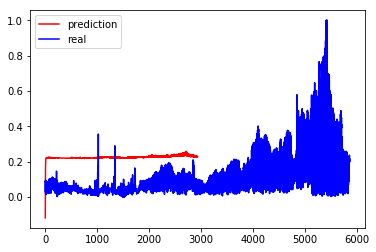

In [74]:
plt.plot(pred_test, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.legend(loc='best')
plt.show()